# Install dependencies

In [7]:

!pip install tensorflow datasets matplotlib seaborn pydot

In [3]:
!pip install wandb --upgrade

# Import necessary libraries

In [8]:

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
import datetime
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [9]:
# Define TensorBoard log directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Load dataset

In [10]:

(ds_train, ds_test), ds_info = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True, with_info=True)




Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.0STVJ7_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.0STVJ7_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.0STVJ7_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


# Preprocess dataset (tokenization & padding)

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 10000
EMBEDDING_DIM = 128
MAX_LEN = 500

In [12]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts([text.numpy().decode('utf-8') for text, _ in ds_train])

train_texts = tokenizer.texts_to_sequences([text.numpy().decode('utf-8') for text, _ in ds_train])
train_labels = np.array([label.numpy() for _, label in ds_train])

test_texts = tokenizer.texts_to_sequences([text.numpy().decode('utf-8') for text, _ in ds_test])
test_labels = np.array([label.numpy() for _, label in ds_test])

train_texts = tf.keras.preprocessing.sequence.pad_sequences(train_texts, maxlen=MAX_LEN)
test_texts = tf.keras.preprocessing.sequence.pad_sequences(test_texts, maxlen=MAX_LEN)


# Build LSTM model

In [15]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [18]:
# Build the model explicitly before visualizing
model.build(input_shape=(None, MAX_LEN))


# Save and display model architecture

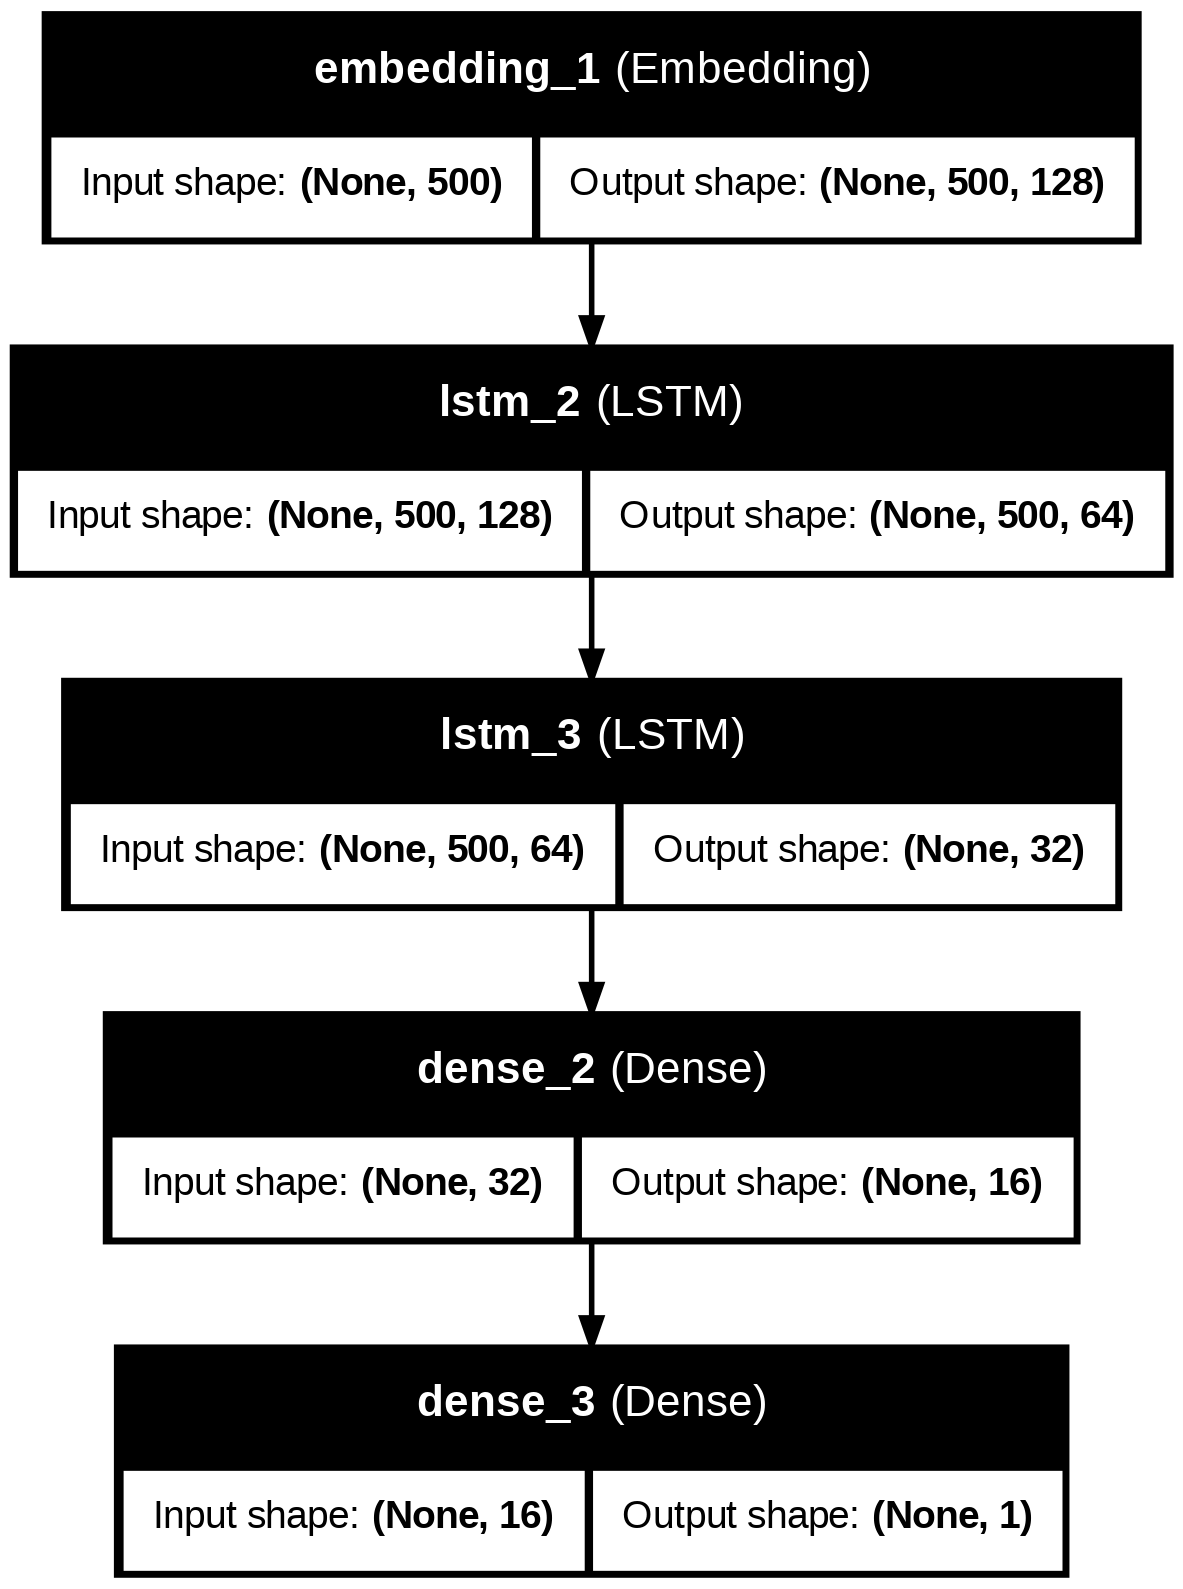

In [19]:

# Save and display model architecture
plot_model(model, to_file='imdb_model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(filename='imdb_model.png')


# Model Summary

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 500, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 500, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,342,369 (5.12 MB)

 Trainable params: 1,342,369 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [21]:

history = model.fit(train_texts, train_labels, epochs=5, batch_size=BATCH_SIZE,
                    validation_data=(test_texts, test_labels), callbacks=[tensorboard_callback])




Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.7339 - loss: 0.4960 - val_accuracy: 0.8714 - val_loss: 0.3181
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.9010 - loss: 0.2520 - val_accuracy: 0.8514 - val_loss: 0.3598
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 494s 1s/step - accuracy: 0.9147 - loss: 0.2276 - val_accuracy: 0.8371 - val_loss: 0.4042
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.9175 - loss: 0.2205 - val_accuracy: 0.8464 - val_loss: 0.3754
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.9153 - loss: 0.2209 - val_accuracy: 0.7410 - val_loss: 0.5371


# Evaluate model

In [22]:

y_pred = (model.predict(test_texts) > 0.5).astype("int32")
print(classification_report(test_labels, y_pred))


782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 121ms/step
              precision    recall  f1-score   support

           0       0.86      0.58      0.69     12500
           1       0.68      0.90      0.78     12500

    accuracy                           0.74     25000
   macro avg       0.77      0.74      0.73     25000
weighted avg       0.77      0.74      0.73     25000



# Confusion Matrix

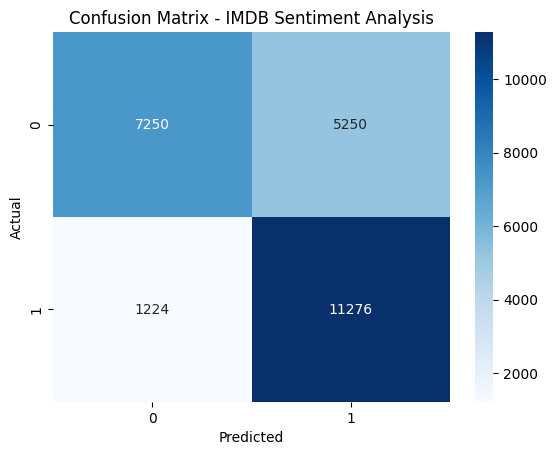

In [23]:


cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - IMDB Sentiment Analysis")
plt.show()



# ROC Curve

782/782 ━━━━━━━━━━━━━━━━━━━━ 91s 116ms/step


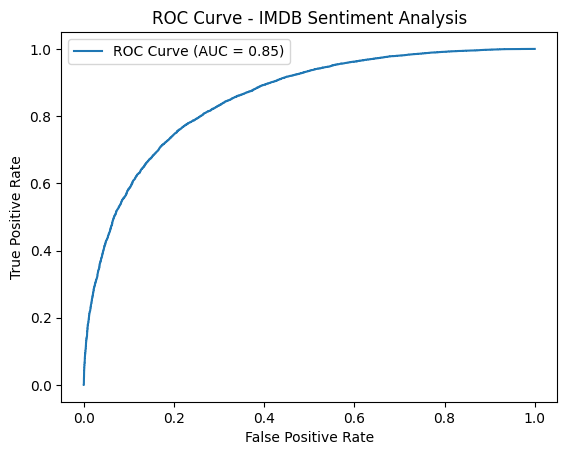

In [24]:

fpr, tpr, _ = roc_curve(test_labels, model.predict(test_texts))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(auc(fpr, tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve - IMDB Sentiment Analysis")
plt.show()



In [ ]:
# Launch TensorBoard in Google Colab
%load_ext tensorboard
%tensorboard --logdir logs/fit